In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Passo-a-passo:
1. calcular $L_n$ e $R$ pela fórmula (atenção com as unidades)
* para $R$, $W_L$ permanece o mesmo (valor não fornecido, considerar 90% da largura da coluna?) e $W_H$ é zero
* é possível já calcular $L_{n,i}$ e $R_i$ nesse passo a partir de $x_{n,i}$
$$
$$
2. Resolver equilíbrio VL para obter $y_{n,i}$ e T
* Primeiro, calcula-se $\gamma_{n,i}$ a partir de $x_{n,i}$ e solubilidades/volumes molares disponibilizados
* A pressão de saturação pode ser calculada normalmente utilizando os parâmetros de Antoine e um chute inicial da temperatura
* Para o cálculo final de $y_{n,i}$, segue-se a formulação da Lei de Raoult, porém levando em consideração a não-idealidade ($\gamma_{n,i}$), conforme mostrado acima. Como o vapor é considerado ideal, a formulação da Lei de Dalton se mantém inalterada.
$$
$$
3. calcular $H^V_{B, i}$, $\lambda$ e $H^L_{B, i}$ em energia por moles pela fórmula, considerando a temperatura encontrada no passo 2.
* Calcular $H^V_B$ a partir de $\sum^i_0 H^V_{B, i}\cdot y_{B, i}$
* Calcular $H^L_B$ a partir de $\sum^i_0 H^L_{B, i}\cdot x_{B, i}$
$$
$$
4. calcular $H^V_{n,i}$ e $H^L_{n,i}$ na unidade de energia por volume da mesma forma que foi feita no passo 3 para chegar em $H^V_n$ e $H^L_n$
$$
$$
5. Supor $\dot{m}_n\dot{H}^L_n=0$ e encontrar $V_n$ a partir de $V_B$
* A suposição feita acima assume que $Q_R$ é utilizado pura e simplesmente para evaporar a parte líquida no reboiler, uma suposição razoável pois, na prática, a temperatura de ebulição geralmente não varia mais do que 5% em destilações. Por causa disso, têm-se a fórmula mostrada acima para $V_B$, que para $V_n$  e $V_N$ pode ser expressada como:
$$
$$
$$
V_n = \frac{Q_R + L_{n+1}\cdot H^L_{n+1}}{H^V_n}
$$
$$
$$
$$
V_N = \frac{Q_R + R\cdot H^L_{D}}{H^V_N}
$$

In [ ]:
# Extração de parâmetros de diferentes planilhas

def extrai_params_C(comp,df):  # = Capacidade calorifica + dens

    nc=len(comp)
    a1,a2,a3,a4,rho=np.zeros(nc),np.zeros(nc),np.zeros(nc),np.zeros(nc),np.zeros(nc)

    for i in range(nc):
        idx = df[df['Composto']==comp[i]].index[0]
        a1[i] = df.loc[idx]['a1']
        a2[i] = df.loc[idx]['a2']
        a3[i] = df.loc[idx]['a3']
        a4[i] = df.loc[idx]['a4']
        rho[i] = df.loc[idx]['d (g/mL)']
    return a1, a2, a3, a4, rho


def extrai_params_Ant(comp,df): # = Parametros Antoine

    nc=len(comp)
    A,B,C,Tmin,Tmax=np.zeros(nc),np.zeros(nc),np.zeros(nc),np.zeros(nc),np.zeros(nc)

    for i in range(nc):
        idx = df[df['Composto']==comp[i]].index[0]
        A[i] = df.loc[idx]['A']
        B[i] = df.loc[idx]['B']
        C[i] = df.loc[idx]['C']
        Tmin[i] = df.loc[idx]['Tmin (K)']
        Tmax[i] = df.loc[idx]['Tmax (K)']
    return A, B, C, Tmin, Tmax


def extrai_params_unit(comp,df): # = Planilhas com apenas uma coluna

    nc=len(comp)
    var=np.zeros(nc)

    for i in range(nc):
        idx = df[df['Composto']==comp[i]].index[0]
        var[i] = df.loc[idx][-1]
    return var

In [ ]:
# Correntes Líquidas saindo de cada prato

def Saida_Liq(MW, DENS, DCOL, x, m):

  W_L = DCOL/15 #in
  MWA = []
  DENSA = []

  for i in range(1,N+2):
    MWA = np.append(MWA, MW[0]*x[i]+MW[1]*x[i+(N+2)]+MW[2]*x[i+2*(N+2)])            # g/mol
    DENSA = np.append(DENSA, DENS[0]*x[i]+DENS[1]*x[i+(N+2)]+DENS[2]*x[i+2*(N+2)])  # g/cm^3

  DENSA = DENSA*62.428    # g/cm^3 -> lb/ft^3
  m = m/453.6             #    mol -> lbmol

  # Considerar W_H = 0
  L = (DENSA*W_L*999*(183.2*m*MWA/(DENSA*DCOL**2))**1.5)*453.6/(MWA*60)       # mol/min
  L = np.append(0, L)
  L[-1] = L[-2]            # Medida de contenção
  return L

In [ ]:
# Conjunto de funções para o equilíbrio Vapor-Líquido

def Hildebrand(x, delta, Volmol, T): # Modelo de solução regular de Hildebrand

  delta_ = (delta*x*Volmol).sum()/(x*Volmol).sum()
  lngamma = (Volmol*(delta-delta_)**2)/((R/4.184)*T)
  return np.exp(lngamma)


def funbol(T,x,A,B,C,P,delta,Volmol): # Função de auxílio para Bol_T

    nc = len(x)
    var = P
    for i in range(nc):
        var -= Hildebrand(x, delta, Volmol, T)[i]*x[i]*np.exp((A[i]-B[i]/(T+C[i])))
    return var


def Bol_T (x,A,B,C,P,delta,Volmol): # Encontra a temperatura e composição de bolha dado P cte

    T = sp.optimize.fsolve(funbol,300,args=(x,A,B,C,P,delta,Volmol))[0]
    Psat = np.exp((A-B/(T+C)))

    K = Hildebrand(x, delta, Volmol, T)*(Psat/P)
    y = K*x

    # if n > 0:
    #   y = nu*(y-y_ant)+y_ant

    if abs(y.sum()-1) > 1e-9:
      print(f'Aviso: ysum está divergindo ({np.round(y,6)} = {np.round(y.sum(),6)}). Imprecisões podem ser significativas')
    return T, y

In [ ]:
# Cálculo das entalpias molares por componente por fase
# Considerando liquido saturado, T = Teb ou T de bolha
# Considerando T0 = 0 --> deltaT = T

def Entalpias(y, x, T):

  H_L, H_V = np.zeros(N+2), np.zeros(N+2)

  for i in range(N+2):
    H_Vi = (a1*T[i] + a2*T[i]**2/2 + a3*T[i]**3/3 + a4*T[i]**4/4)                 # J/mol por componente por prato
    Hvapi = R*T[i]**2*(B/(C+T[i])**2)                                             # J/mol por componente por prato
    H_Li = H_Vi - Hvapi                                                           # J/mol por componente por prato

    H_L[i] = (H_Li*x[i]).sum()                                                    # J/mol por prato
    H_V[i] = (H_Vi*y[i]).sum()                                                    # J/mol por prato

    # print('Entalpias por componente', H_Li, H_Vi, Hvapi)
    # print('Entalpias totais do prato', H_L[i], H_V[i])

  return H_L, H_V

In [ ]:
# Extração de diversos parâmetros relevantes ao problema

teste = pd.read_excel('/content/gdrive/MyDrive/Destilação batelada multicomponente trabalho/Dados destil batelada.xlsx',
                     sheet_name = ['Parametros Antoine', 'Capacidade calorifica + dens', 'Solubilidades', 'Massas Molares', 'Volumes Molares'])

compostos = ['Cyclohexane', 'n-Heptane', 'Toluene']

a1, a2, a3, a4, rho = extrai_params_C(compostos, teste.get('Capacidade calorifica + dens'))
A, B, C, Tmin, Tmax = extrai_params_Ant(compostos, teste.get('Parametros Antoine'))
solub = extrai_params_unit(compostos, teste.get('Solubilidades'))    # (cal/mL)^0.5
Mmolar = extrai_params_unit(compostos, teste.get('Massas Molares'))  # uma
Vmolar = extrai_params_unit(compostos, teste.get('Volumes Molares')) # mL/mol

In [ ]:
global prod
global tempo
global D
prod = np.zeros(len(compostos))
tempo = []
D = 0

def batch_distill(t, x): # EDO

  global prod
  global tempo
  global D

  if (abs(x[x<0]) > 1e-6).any():
    print(f'Atenção: valores negativos ({np.round(x[x<0],2)}) nos índices {np.where(x<0)[0]}. t = {round(t,2)}')
    return
  else:
    x[x<0] = 0

  if x[N+1]/x[-1] >= 0.97:
    tempo = np.append(tempo, t)
    if len(tempo) == 1:
      print()
      print(f'Ciclo de produção de ciclohexano iniciada: {np.round(tempo[0],2)} min')
  else:
    if len(tempo) > 1:
      prod = np.vstack([prod, [(x0[:N+2] - x[:N+2]).sum(),
                               (x0[N+2:2*(N+2)] - x[N+2:2*(N+2)]).sum(),
                               (x0[2*(N+2):3*(N+2)] - x[2*(N+2):3*(N+2)]).sum()]])
      print(f'Ciclo de produção de ciclohexano encerrada após {np.round(tempo[-1]-tempo[0],2)} min')
      print(f'Quantidade: {np.round(prod[-1].sum()-prod[-2].sum(),2)} mol // \
Pureza do ciclo atual: {np.round((prod[-1][0]-prod[-2][0])*100/(prod[-1].sum()-prod[-2].sum()),2)} % // \
Pureza acumulada do ciclohexano: {np.round(prod[-1][0]*100/prod[-1].sum(),2)} %')
      print()
      tempo = []

  # ------ Inicializando variáveis relevantes ---------------------------------

  dxdt = np.zeros(len(x))
  T, y, xmat = [], [], []
  V = np.zeros(N+2)

  nmat = x.reshape(int(len(x)/(N+2)),N+2)
  ntot = nmat[-1]
  nmat = nmat[:-1]
  nmat = nmat.ravel(order='F').reshape(N+2,len(compostos))
  for n in range(N+2):
    xmatapp = nmat[n]/ntot[n]
    if abs(xmatapp.sum()-1) > 1e-4:
      print(f'AVISO: xsum do prato {n} está divergindo \
({np.round(xmatapp,6)} = {np.round(xmatapp.sum(),5)}). \
Imprecisões podem ser significativas. t = {round(t,3)} min')
    xmat = np.append(xmat, xmatapp)

  xmat = xmat.reshape(N+2,len(compostos))

  # ------ Cálculos algébricos ------------------------------------------------

  L = Saida_Liq(Mmolar, rho, DCOL, xmat.ravel(order='F'), ntot[1:])

  for n in range(N+2):  # Equilíbrio VL em cada prato
    Tapp, yapp = Bol_T(xmat[n],A,B,C,Ptot,solub,Vmolar)
    T = np.append(T, Tapp)
    y = np.append(y, yapp)
  ymat = y.reshape(N+2, len(compostos))
  ymat[-1] = 0

  H_L, H_V = Entalpias(ymat, xmat, T)

  for n in range(N+1): # Saídas de vapor em cada prato
    V[n] = (L[n+1]*H_L[n+1] + Q_R)/H_V[n]

  for i in range(10):                                    # Medida de contenção; pode ser interpretado como um controlador de nível do tanque do condensador
    L[-1] = V[-2]
    V[-2] = (L[-1]*H_L[-1] + Q_R)/H_V[-2]

  if x[N+1]/x[-1] >= 0.97: # Definição da vazão de destilado para fora da coluna
    dccdt = ((V[-2]*ymat[-2][0] - (V[-2])*xmat[-1][0]))*5/4
    absdccdt = dccdt - abs(dccdt)
    D = 1.8/(1+5*np.exp(-0.05*(t-tempo[0]-40))) + 40*absdccdt*(1-(absdccdt))**0.1
  else:
    D = D*1.001**(1.8-D)
  D = (D + abs(D))/2

  L[-1] = V[-2] - D                                      # Tal que a variação de matéria no tanque condensador seja zero

  # ------ Cálculo do vetor de variações --------------------------------------

  # Variação do balanço molar global
  dxdt[3*(N+2)] = L[1] - V[0]
  for n in range(1,N+1):
    dxdt[n+3*(N+2)] = L[n+1] + V[n-1] - L[n] - V[n]
  dxdt[-1] = V[-2] - L[-1] - D                           # Teoricamente, 0

  # Variação do balanço molar por componente
  for j in range(len(compostos)):
    dxdt[j*(N+2)] = (L[1]*xmat[1][j] - V[0]*ymat[0][j])
    for n in range(1,N+1):
      dxdt[n+j*(N+2)] = L[n+1]*xmat[n+1][j] + V[n-1]*ymat[n-1][j] - L[n]*xmat[n][j] - V[n]*ymat[n][j]
    dxdt[(j+1)*(N+2)-1] = (V[-2]*ymat[-2][j] - (L[-1]+D)*xmat[-1][j])

  dxdt[dxdt > x] = x[dxdt > x]

  return dxdt

# Inicialização de vetores e valores iniciais

```
# Vetorização:   0,   1,   2,   3,  ...   ,   10,   11,   12,   13   (tamanho = 14 = N+2)
# Nome pratos:   B,   1,   2,   3,  ...   ,   10,   11,   12,   D
#           L:   0,  L1,  L2,  L3,  ...   ,  L10,  L11,  L12,   R_liq
#           V:  VB,  V1,  V2,  V3,  ...   ,  V10,  V11,  V12,   0
```
Idem para x1, x2, x3, y1, y2, y3, m, HL, HV
$$
$$
```
# Organização do vetor inicial por índices:
# Tamanho = 14*4 = 56
#  0 - 13: m1
# 14 - 27: m2
# 28 - 41: m3 (= m - m1 - m2)
# 42 - 55: mdot

```



In [ ]:
R = 8.315                   # J/mol.K (dividir por 4.184 para cal/mol.K)

# Propriedades da coluna
N = 12
nu = 0.8                    # ou 80%
Ptot = 760                  # mm Hg
DCOL = 75/2.54              # in
Q_R = 200*4184              # J/min

# Alimentação
F = 30000                   # mol, Destilação em batelada
z = [0.4, 0.4, 0.2]         # mol, líquido saturado (x = z)
m0_D = 1000                 # mol
m0 = np.ones(N)*30          # mol
m0_B = F-m0_D-m0.sum()      # mol

m0 = np.append(m0, m0_D)
m0 = np.append(m0_B, m0)


In [ ]:
x0 = []

for i in range(len(z)):
  x0 = np.append(x0, z[i]*m0)

x0 = np.append(x0, m0)
x0

array([1.1456e+04, 1.2000e+01, 1.2000e+01, 1.2000e+01, 1.2000e+01,
       1.2000e+01, 1.2000e+01, 1.2000e+01, 1.2000e+01, 1.2000e+01,
       1.2000e+01, 1.2000e+01, 1.2000e+01, 4.0000e+02, 1.1456e+04,
       1.2000e+01, 1.2000e+01, 1.2000e+01, 1.2000e+01, 1.2000e+01,
       1.2000e+01, 1.2000e+01, 1.2000e+01, 1.2000e+01, 1.2000e+01,
       1.2000e+01, 1.2000e+01, 4.0000e+02, 5.7280e+03, 6.0000e+00,
       6.0000e+00, 6.0000e+00, 6.0000e+00, 6.0000e+00, 6.0000e+00,
       6.0000e+00, 6.0000e+00, 6.0000e+00, 6.0000e+00, 6.0000e+00,
       6.0000e+00, 2.0000e+02, 2.8640e+04, 3.0000e+01, 3.0000e+01,
       3.0000e+01, 3.0000e+01, 3.0000e+01, 3.0000e+01, 3.0000e+01,
       3.0000e+01, 3.0000e+01, 3.0000e+01, 3.0000e+01, 3.0000e+01,
       1.0000e+03])

# Resolução da EDO

In [ ]:
sol = sp.integrate.solve_ivp(batch_distill, [0, 10000], x0)


Ciclo de produção de ciclohexano iniciada: 372.52 min
Ciclo de produção de ciclohexano encerrada após 6276.85 min
Quantidade: 9212.41 mol // Pureza do ciclo atual: 98.68 % // Pureza acumulada do ciclohexano: 98.68 %



In [ ]:
xmat_t = np.zeros((14,3))
for t in range(sol.y.shape[1]):
  xmat_stack = sol.y[:, t][:3*(N+2)].reshape(N+2,len(compostos),order = 'F')
  xmat_t = np.dstack((xmat_t,xmat_stack))

In [ ]:
ymat_t = np.zeros((14,3))

for t in range(1,sol.y.shape[1]):
  Tt = []
  yt = []
  for n in range(N+2):
    Tappt, yappt = Bol_T(xmat_t[:, :, t][n],A,B,C,760,solub,Vmolar)
    Tt = np.append(Tt, Tappt)
    yt = np.append(yt, yappt)
  ymat_stack = yt.reshape(N+2, len(compostos))
  ymat_t = np.dstack((ymat_t,ymat_stack))

# Gráficos

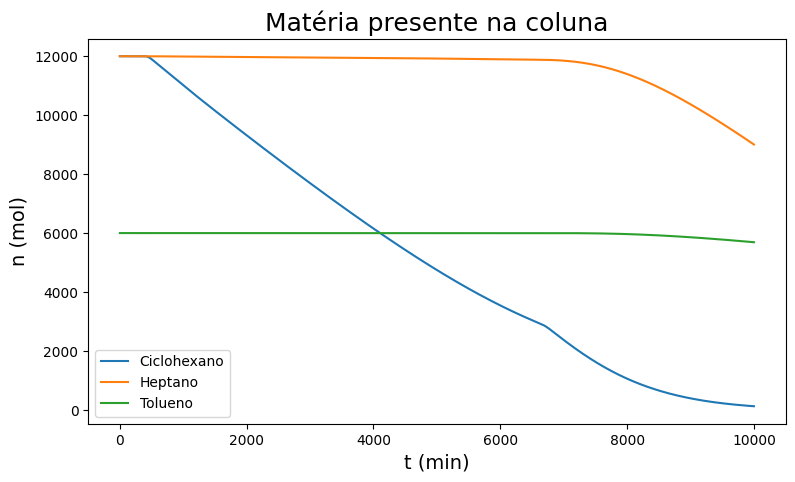

In [ ]:
plt.figure(figsize=(9,5))

plt.plot(sol.t, sol.y[:14].sum(axis=0), label=f'Ciclohexano')
plt.plot(sol.t, sol.y[14:28].sum(axis=0), label=f'Heptano')
plt.plot(sol.t, sol.y[28:42].sum(axis=0), label=f'Tolueno')

plt.xlabel('t (min)', fontsize=14)
plt.ylabel('n (mol)', fontsize=14)

plt.title('Matéria presente na coluna', fontsize=18)
plt.legend()
plt.show()

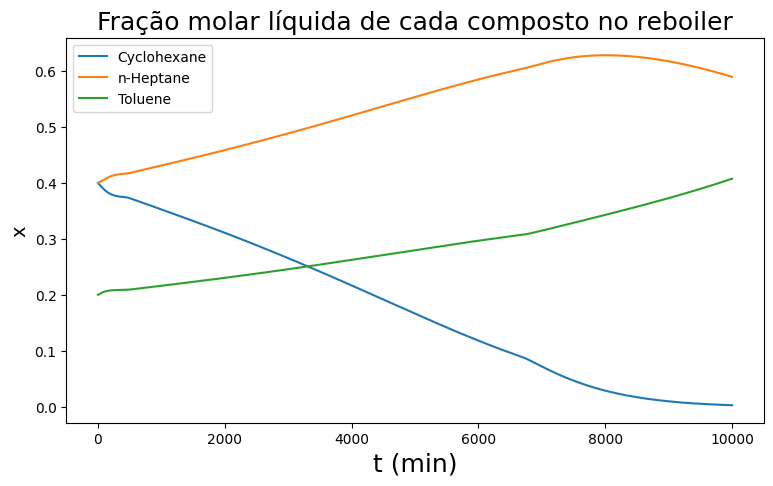

In [ ]:
plt.figure(figsize=(9,5))

for i in range(3):
  plt.plot(sol.t, sol.y[(N+2)*(i)]/sol.y[-N-2], label=f'{compostos[i]}')

plt.xlabel('t (min)', fontsize=18)
plt.ylabel('x', fontsize=14)

plt.title('Fração molar líquida de cada composto no reboiler', fontsize = 18)
plt.legend()
plt.show()

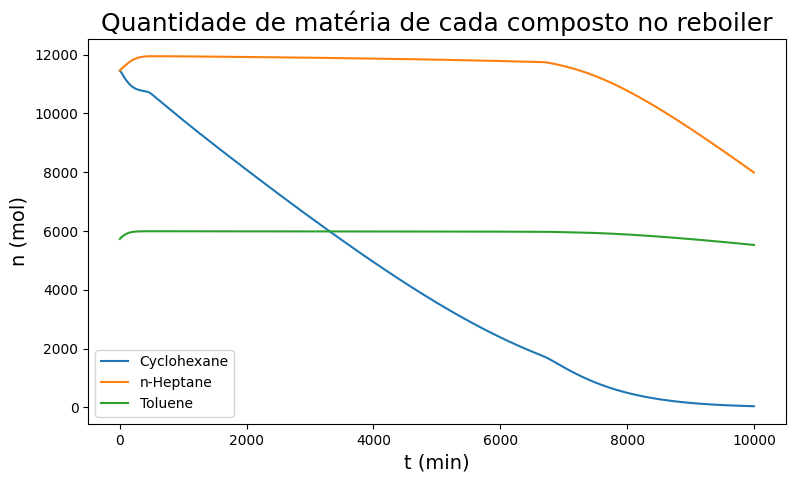

In [ ]:
plt.figure(figsize=(9,5))

for i in range(3):
  plt.plot(sol.t, sol.y[(N+2)*(i)], label=f'{compostos[i]}')

plt.xlabel('t (min)', fontsize=14)
plt.ylabel('n (mol)', fontsize=14)

plt.title('Quantidade de matéria de cada composto no reboiler', fontsize = 18)
plt.legend()
plt.show()

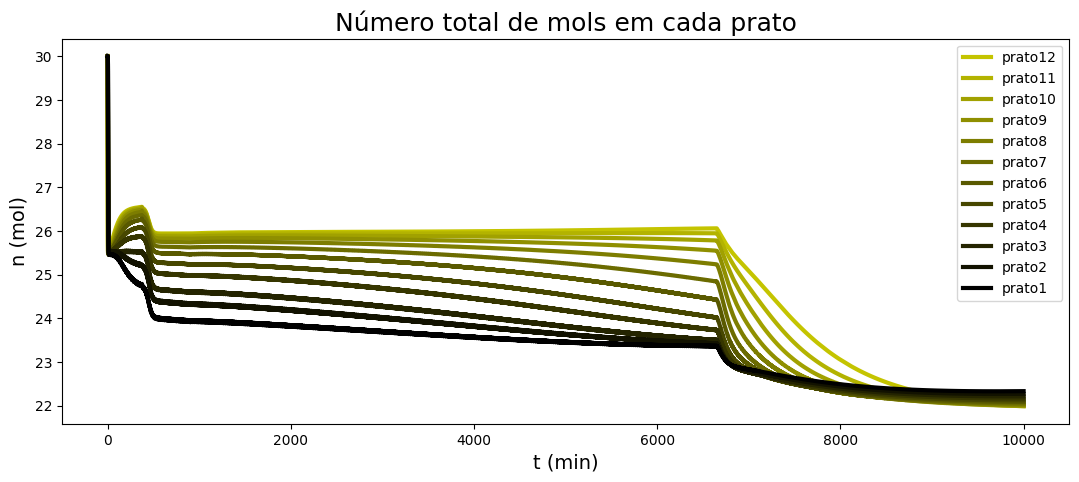

In [ ]:
plt.figure(figsize=(13,5))

for n in range(N-1,-1,-1):
  plt.plot(sol.t, sol.y[n+1+3*(N+2)], linewidth=3, label=f'prato{n+1}', color=(n*0.07, n*0.07, n*0))

plt.xlabel('t (min)', fontsize=14)
plt.ylabel('n (mol)', fontsize=14)

plt.title('Número total de mols em cada prato', fontsize = 18)
plt.legend()
plt.show()

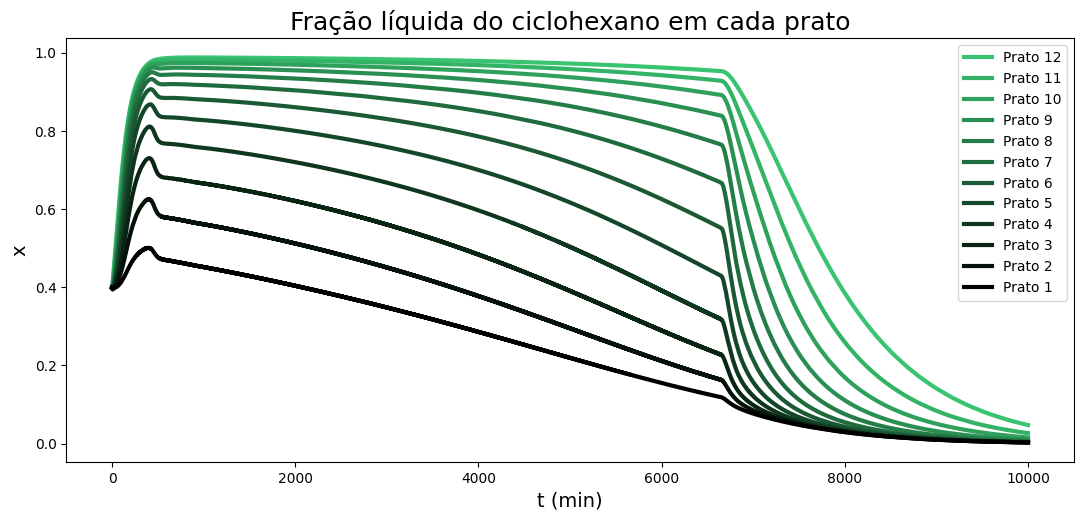

In [ ]:
plt.figure(figsize=(13,5.5))

for n in range(N-1,-1,-1):
  plt.plot(sol.t, sol.y[n+1]/sol.y[n+1+3*(N+2)], linewidth=3, label=f'Prato {n+1}', color=(n*0.02, n*0.07, n*0.04))

plt.xlabel('t (min)', fontsize=14)
plt.ylabel('x', fontsize=14)

plt.title('Fração líquida do ciclohexano em cada prato', fontsize = 18)
plt.legend()
plt.show()

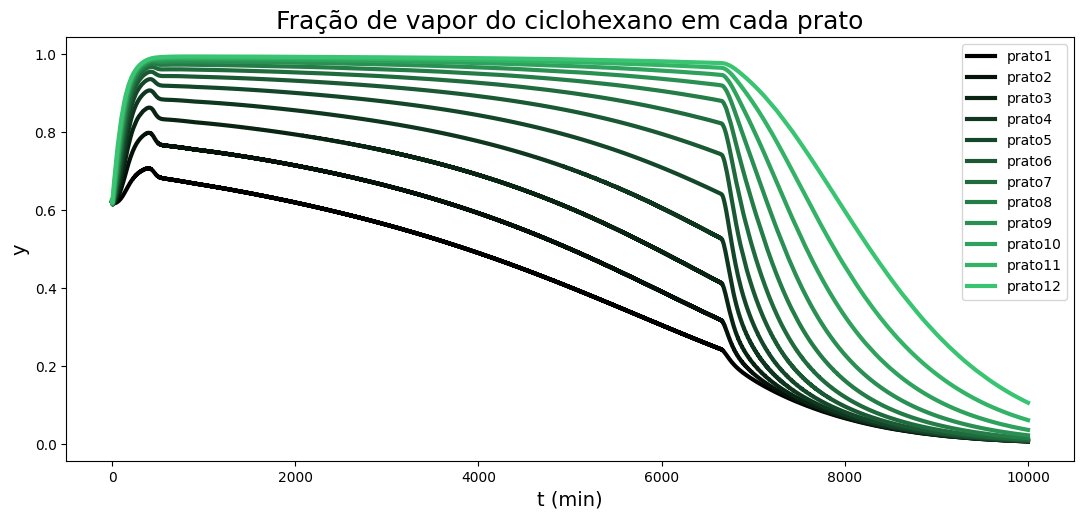

In [ ]:
plt.figure(figsize=(13,5.5))

for n in range(N):
  plt.plot(sol.t[1:], ymat_t[n+1,0,1:], linewidth=3, label=f'prato{n+1}',color=(n*0.02, n*0.07, n*0.04))

plt.xlabel('t (min)', fontsize=14)
plt.ylabel('y', fontsize=14)

plt.title('Fração de vapor do ciclohexano em cada prato', fontsize = 18)
plt.legend()
plt.show()

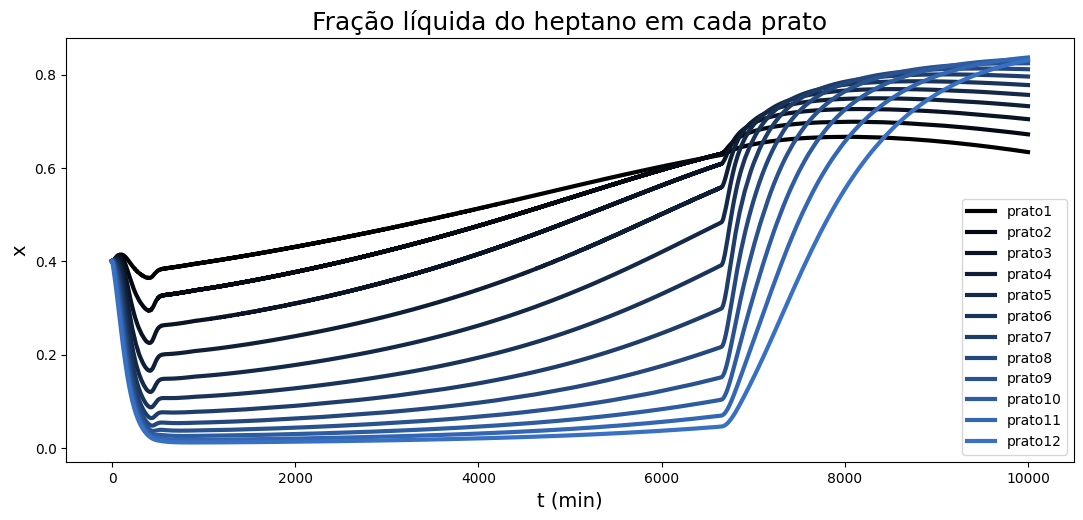

In [ ]:
plt.figure(figsize=(13,5.5))

for n in range(N):
  plt.plot(sol.t, sol.y[n+1+(N+2)]/sol.y[n+1+3*(N+2)], linewidth=3, label=f'prato{n+1}', color=(n*0.02, n*0.04, n*0.07))

plt.xlabel('t (min)', fontsize=14)
plt.ylabel('x', fontsize=14)

plt.title('Fração líquida do heptano em cada prato', fontsize = 18)
plt.legend()
plt.show()

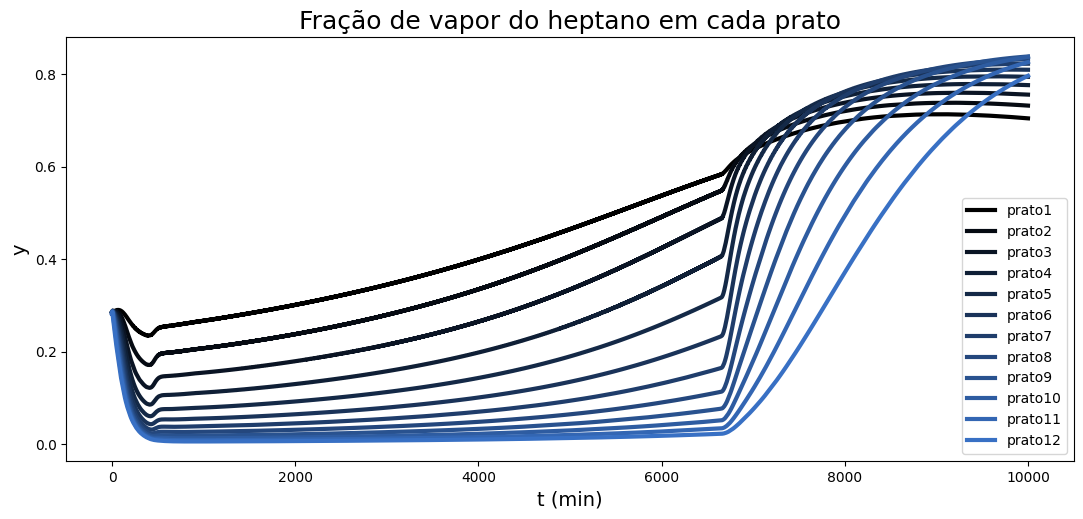

In [ ]:
plt.figure(figsize=(13,5.5))

for n in range(N):
  plt.plot(sol.t[1:], ymat_t[n+1,1,1:], linewidth=3, label=f'prato{n+1}', color=(n*0.02, n*0.04, n*0.07))

plt.xlabel('t (min)', fontsize=14)
plt.ylabel('y', fontsize=14)

plt.title('Fração de vapor do heptano em cada prato', fontsize = 18)
plt.legend(loc='lower right')
plt.show()

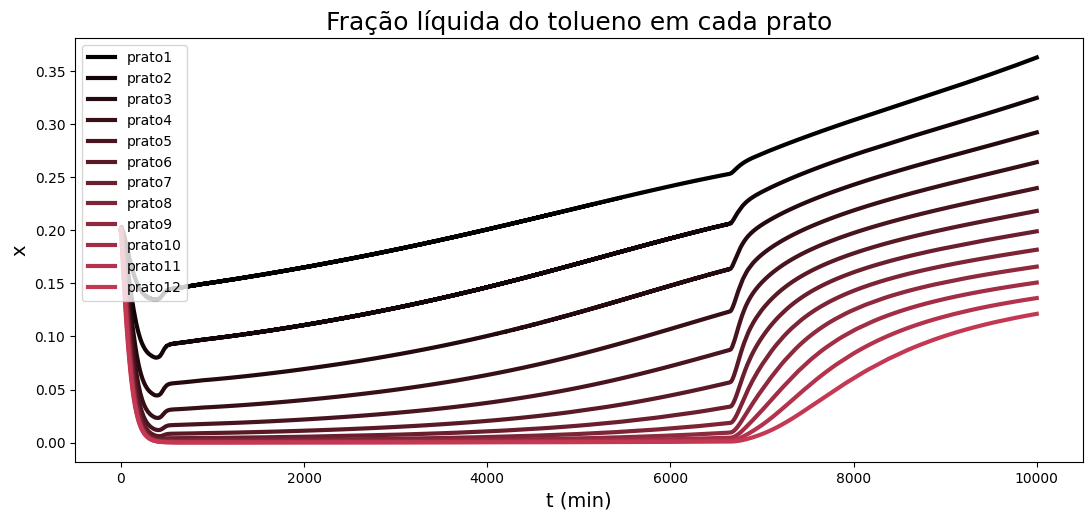

In [ ]:
plt.figure(figsize=(13,5.5))

for n in range(N):
  plt.plot(sol.t, sol.y[n+1+2*(N+2)]/sol.y[n+1+3*(N+2)], linewidth=3, label=f'prato{n+1}',color=(n*0.07, n*0.02, n*0.03))

plt.xlabel('t (min)', fontsize=14)
plt.ylabel('x', fontsize=14)

plt.title('Fração líquida do tolueno em cada prato', fontsize = 18)
plt.legend()
plt.show()

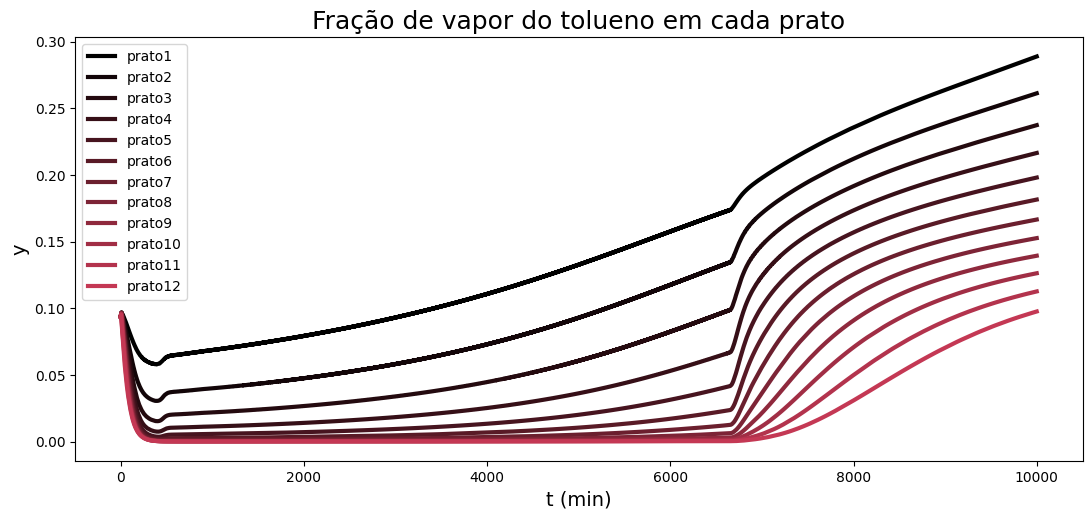

In [ ]:
plt.figure(figsize=(13,5.5))

for n in range(N):
  plt.plot(sol.t[1:], ymat_t[n+1,2,1:], linewidth=3, label=f'prato{n+1}', color=(n*0.07, n*0.02, n*0.03))

plt.xlabel('t (min)', fontsize=14)
plt.ylabel('y', fontsize=14)

plt.title('Fração de vapor do tolueno em cada prato', fontsize = 18)
plt.legend()
plt.show()

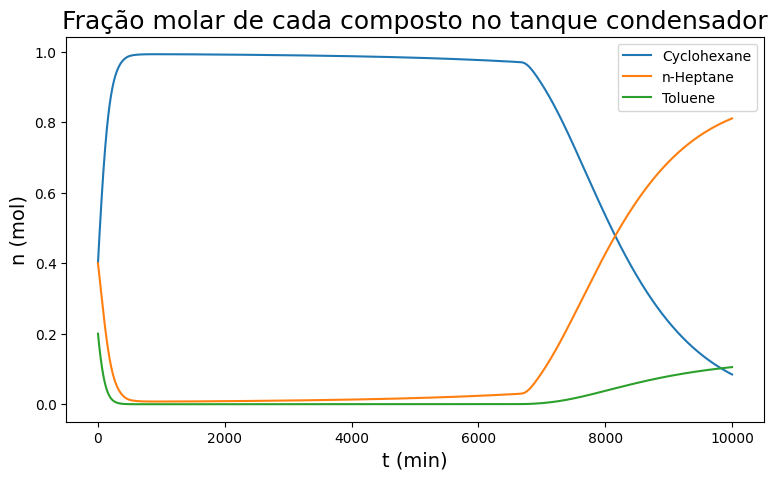

In [ ]:
plt.figure(figsize=(9,5))
for i in range(3):
  plt.plot(sol.t, sol.y[(N+2)*(i+1)-1]/sol.y[-1], label=f'{compostos[i]}')

plt.xlabel('t (min)', fontsize=14)
plt.ylabel('n (mol)', fontsize=14)

plt.title('Fração molar de cada composto no tanque condensador', fontsize = 18)
plt.legend()
plt.show()